# Libs and Modules

In [96]:
pip install emoji


In [97]:
pip install demoji


In [98]:
#!pip install emoji --upgrade
#26 march latest

In [99]:
import pandas as pd
import numpy as np
import io

import json
import re
import string
import demoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import emoji
from collections import Counter

# File upload and initial dataframes

In [100]:
def load_and_extract_data(file_paths):
    extracted_data_educated = []
    extracted_data_uneducated = []

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)

        for entry in data:
            user = entry.get('user', {})
            name = user.get('name', None)
            startUrl = entry.get('startUrl', None)
            location = user.get('location', None)
            description = user.get('description', None)
            full_text = entry.get('full_text', None)

            extracted_data = {
                'name': name,
                'startUrl': startUrl,
                'location': location,
                'description': description,
                'full_text': full_text
            }

            if 'Educated' in file_path:
                extracted_data_educated.append(extracted_data)
            elif 'Uneducated' in file_path:
                extracted_data_uneducated.append(extracted_data)


    df_educated = pd.DataFrame(extracted_data_educated)
    df_uneducated = pd.DataFrame(extracted_data_uneducated)


    return df_educated, df_uneducated

file_paths = ['/content/Educated.json', '/content/Uneducated.json']
df_educated, df_uneducated = load_and_extract_data(file_paths)

In [101]:
print(df_educated.shape)
print(df_uneducated.shape)


(6449, 5)
(7628, 5)


In [102]:
df_educated['startUrl'] = df_educated['startUrl'].str.split('/').str[3]
df_uneducated['startUrl'] = df_uneducated['startUrl'].str.split('/').str[3]


In [103]:
df_educated.head()

,name,startUrl,location,description,full_text
0,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"For too long, Rishi Sunak has allowed tax dodg..."
1,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"Britain’s pensioners deserve certainty, and fo..."
2,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It’s fantastic to welcome Dr Dan Poulter MP to...
3,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was an honour to meet with @3dadswalking to...
4,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was a pleasure speaking with @GylesB1 about...


## Exploring the missing usernames during Apify scrape

In [104]:
educated_names = df_educated['startUrl'].unique()
print(len(educated_names))
print(educated_names)

70
['Keir_Starmer' 'thatginamiller' 'MarinaHyde' 'dsallentess' 'agordonreed'
 'kinggary' 'danariely' 'CassSunstein' 'HenryLouisGates' 'R_Thaler'
 'nadiamdrake' 'jordanbpeterson' 'JonHaidt' 'lauriesantos'
 'InertialObservr' 'bencbartlett' 'victorvalbert' 'HyperboIeva'
 'Liv_Lanes' 'michiokaku' 'sapinker' 'earltcampbell' 'bgavran3'
 'stevenstrogatz' 'JaneGoodallInst' 'SylviaEarle' 'divbyzero'
 'JeffreyASachs' 'LHSummers' 'RobertJShiller' 'RBReich' 'JosephEStiglitz'
 'MikeBloomberg' 'AnnPettifor' 'ProfSteveKeen' 'kahneman_daniel'
 'USAmbGermany' 'amanpour' 'PeterDiamandis' 'tylercowen' 'DrSidMukherjee'
 'PeterSinger' 'MazzucatoM' 'DrTempleGrandin' 'RichardJMurphy' 'jonlis1'
 'neiltyson' 'benbernanke' 'CondoleezzaRice' 'SenWarren' 'johnlegend'
 'DrBrianMay' 'sherylsandberg' 'lirarandall' 'tim_cook' 'PowerUSAID'
 'ericschmidt' 'elonmusk' 'angeladuckw' 'BillGates' 'paulkrugman'
 'maejemison' 'Atul_Gawande' 'AmbassadorRice' 'preskill' 'ZierlerDavid'
 'AndreasAtETH' 'nattyover' 'jaygambetta' '

In [105]:
uneducated_names = df_uneducated['startUrl'].unique()
print(len(uneducated_names))
print(uneducated_names)

80
['ReachTWR' 'pearlythingz' 'Moneybaglives' 'MattWalshBlog'
 'Leonarda_Jonie' 'brutedeforce' 'paleochristcon' 'mikerashid7'
 'Cole_Walmsley' '_Mama_Mia10' 'Eminem' 'purgethemarxist' 'markwahlberg'
 'katyperry' 'realityspammer' 'garrettcmpbll' 'HilarySwank'
 'JessicaSimpson' 'RyanGosling' 'youngkingsgrow' 'TateTheTalisman'
 'MorpheusCentral' 'tatepledge' 'Cobratate' 'Rich_Cooper' 'MsBlaireWhite'
 'stillgray' 'JaniceFiamengo' 'timthetatman' 'Valkyrae' 'Sodapoppintv'
 'dizzykitten7' 'Corpse_Husband' 'MOONMOON_OW' 'Asmongold' 'kidwolf88'
 'summit1g' 'Sykkuno' 'ironmouse' 'azghari_nabil' 'HolyBiblePosts'
 'MercifulMessage' None 'Ohemaa_akyaa89' 'Rydro313' 'bethanyshondark'
 'vers69703' 'yhviis' 'Commendable99' 'pigtailsgyu' 'Iivserene'
 'CamRacerX' 'alowerose' 'jmngaggedme_' 'elliedjarin' 'NyanNyanners'
 'shroud' 'pokimanelol' 'speakwomanese' 'MrLottaHoes' 'Amouranth'
 'StirlingWisdom' 'JoshuaM37848390' 'TatesBestFan' 'JWALLERWins'
 'TateWarPlans' 'DrJoeBoot' 'DenverForMen' 'CRU3LWRLD' 'D

In [106]:

educated_drive_names=pd.read_csv(io.StringIO('''
neiltyson
CondoleezzaRice
benbernanke
SenWarren
johnlegend
lirarandall
DrBrianMay
sherylsandberg
tim_cook
elonmusk
BillGates
ericschmidt
angeladuckw
PowerUSAID
paulkrugman
maejemison
Atul_Gawande
AmbassadorRice
FreemanDys0n
SubirSachdev
preskill
AndreasAtETH
ZierlerDavid
nattyover
LeeBillings
nadiamdrake
InertialObservr
bencbartlett
RRaussendorf
Isaac__kim
victorvalbert
ihdeutsch
oliver_mit
jmchow
jaygambetta
nic_delfosse
S_Flammia
HyperboIeva
earltcampbell
Liv_Lanes
bgavran3
divbyzero
stevenstrogatz
janerrigby
sapinker
JaneGoodallInst
michiokaku
MikeBloomberg
SylviaEarle
Michaelskywal
JeffreyASachs
drewfaustus
LHSummers
CarolDweckDSU
RobertJShiller
JosephEStiglitz
AnnPettifor
ProfSteveKeen
RBReich
mihail_eric
eric_lander
EOWBF
amanpour
USAmbGermany
DrTempleGrandin
kipthorne
kahneman_daniel
JoanCWilliams
PeterDiamandis
DrSidMukherjee
tylercowen
PeterSinger
MazzucatoM
RichardJMurphy
jonlis1
MarinaHyde
thatginamiller
Keir_Starmer
MichaelEPorter
profhamel
agordonreed
dsallentess
kinggary
HenryLouisGates
CassSunstein
R_Thaler
JonHaidt
danariely
jordanbpeterson
lauriesantos
AnnMGraybiel
bill_fischer
RosabethKanter
'''), header=None)


In [107]:

uneducated_drive_names= pd.read_csv(io.StringIO('''
markwahlberg
Eminem
katyperry
HilarySwank
RyanGosling
JessicaSimpson
jessebenisrael
KarenAFox17
Cobratate
youngkingsgrow
tatepledge
Rich_Cooper
BrianHu10
legendOfBens
MsBlaireWhite
stillgray
amberruth17
SchelleaR
sharronloder
rayhodges1930
ChillWill828
JaniceFiamengo
MattWalshBlog
Ilovelatinas36
18thBro
JeffGal6969
ReachTWR
pearlythingz
Moneybaglives
brutedeforce
Leonarda_Jonie
paleochristcon
mikerashid7
_Mama_Mia10
Cole_Walmsley
purgethemarxist
realityspammer
garrettcmpbll
StirlingWisdom
MrLottaHoes
TatesBestFan
tonyrjacobs01
sznmelvin
AfricanTopG_
dudedrew002
realtatespeeech
tristantate_10
JWALLERWins
TateWarPlans
DrJoeBoot
DenverForMen
CRU3LWRLD
doggospain
xdianalandx
Gh0stInTheWire
Vigilante2801
Al_Quran_011
VivianRasna
Rydro313
HolyBiblePosts
azghari_nabil
Rukndin2
vers69703
Iivserene
alowerose
CamRacerX
GamerJob14
jmngaggedme_
pigtailsgyu
yhviis
jjach
Wandazworldz
elliedjarin
pokimanelol
NyanNyanners
shroud
Amouranth
summit1g
dizzykitten7
timthetatman
Valkyrae
Sykkuno
kidwolf88
ironmouse
Sodapoppintv
Asmongold
'''), header=None)



In [108]:
educated_drive_names = educated_drive_names[0].values #changed datatype
uneducated_drive_names =uneducated_drive_names[0].values



educated_apify_set = set(educated_names)
uneducated_apify_set = set(uneducated_names)

educated_set = set(educated_drive_names)
uneducated_set = set(uneducated_drive_names)

non_matching_in_educated = educated_set -  educated_apify_set
non_matching_in_uneducated = uneducated_set -  uneducated_apify_set

# Print non-matching elements
print("Missing names educated", non_matching_in_educated)
print("Missing names uneducated", non_matching_in_uneducated)


Missing names educated {'Isaac__kim', 'MichaelEPorter', 'kipthorne', 'bill_fischer', 'FreemanDys0n', 'RRaussendorf', 'SubirSachdev', 'JoanCWilliams', 'Michaelskywal', 'S_Flammia', 'ihdeutsch', 'drewfaustus', 'EOWBF', 'eric_lander', 'nic_delfosse', 'jmchow', 'AnnMGraybiel', 'RosabethKanter', 'oliver_mit', 'CarolDweckDSU', 'LeeBillings', 'mihail_eric', 'profhamel'}
Missing names uneducated {'realtatespeeech', 'Rukndin2', 'rayhodges1930', 'GamerJob14', 'Wandazworldz', 'AfricanTopG_', 'tonyrjacobs01', 'sznmelvin', 'jessebenisrael', '18thBro', 'sharronloder', 'SchelleaR', 'BrianHu10', 'legendOfBens', 'JeffGal6969', 'ChillWill828', 'dudedrew002', 'amberruth17', 'tristantate_10'}


# Preprocess & EDA

Given the raw input Tweets, to obtain the same pre-processing output, users could employ our TweetNormalizer module.

Installation: pip3 install nltk emoji==0.6.0
The emoji version must be either 0.5.4 or 0.6.0. Newer emoji versions have been updated to newer versions of the Emoji Charts, thus not consistent with the one used for pre-processing our pre-training Tweet corpus.

To identify English Tweets,
we employ the language identification component of fastText (Joulin et al., 2017). We tokenize those English Tweets using “TweetTokenizer” from the NLTK toolkit (Bird et al.,
2009) and use the emoji package to translate
emotion icons into text strings (here, each icon
is referred to as a word token).

We also normalize the Tweets by converting user mentions and
web/url links into special tokens @USER and
HTTPURL, respectively. We filter out retweeted
Tweets and the ones shorter than 10 or longer
than 64 word tokens.

We use a “soft” normalization strategy to all of
the experimental datasets by translating word tokens of user mentions and web/url links into special tokens @USER and HTTPURL, respectively,
and converting emotion icon tokens into corresponding strings

## Remove Links

Removed example: Look the white.head() last row

In [109]:
def process_dataframe(df):
    def remove_http_urls(text):
        if isinstance(text, str):
            return re.sub(r'https?://\S*', '', text)
        return text

    df_processed = df.copy()
    df_processed['full_text_processed'] = df_processed['full_text'].apply(remove_http_urls)
    df_processed.drop(columns=['full_text'], inplace=True)
    return df_processed

In [110]:
df_prep_educated = process_dataframe(df_educated)
df_prep_uneducated = process_dataframe(df_uneducated)


df_prep_educated.head()


,name,startUrl,location,description,full_text_processed
0,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"For too long, Rishi Sunak has allowed tax dodg..."
1,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"Britain’s pensioners deserve certainty, and fo..."
2,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It’s fantastic to welcome Dr Dan Poulter MP to...
3,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was an honour to meet with @3dadswalking to...
4,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was a pleasure speaking with @GylesB1 about...


## Used Hashtags

In [111]:
def extract_and_flatten_hashtags(df):
    hashtags = df['full_text_processed'].str.findall(r'#\w+')
    flat_hashtags = [tag.lower() for sublist in hashtags if sublist is not None for tag in sublist]
    return flat_hashtags

flat_hashtags_educated = extract_and_flatten_hashtags(df_prep_educated)
flat_hashtags_uneducated = extract_and_flatten_hashtags(df_prep_uneducated)

print('Heterosexual hashtags: ',flat_hashtags_educated)
print('LGBTQ hashtags: ',flat_hashtags_uneducated)


Heterosexual hashtags:  ['#epsom', '#ewell', '#wellbeing', '#economy', '#rishisunak', '#bbcbias', '#linekergate', '#dominiccummngs', '#brexit', '#netzero2030', '#ourcommonwealth', '#mapoli', '#magov2022', '#r4today', '#bbc', '#covid2019', '#r4today', '#yellowhammer', '#nodealbrexit', '#endthechaos', '#brexitdeal', '#gbnews', '#howwereopen', '#brexit', '#brokenbritain', '#concretecrisis', '#chichester', '#rishisunak', '#tory', '#violenceagainstwomen', '#withdrawalagreementbill', '#reshuffle', '#davidcameron', '#brexitdisaster', '#generalelectionnow', '#doctorsstrike', '#nhs', '#misbelief', '#danielkahneman', '#angeladavis', '#findingyourroots', '#findingyourroots', '#findingyourroots', '#findingyourroots', '#edwardnorton', '#juliaroberts', '#findingyourroots', '#findingyourroots', '#fyrflashbackfriday', '#watchmenhbo', '#blackhistorymonth', '#behavioraleconomics', '#psychology', '#decisionmaking', '#findingyourroots', '#findingyourroots', '#findingyourroots', '#findingyourroots', '#newy

In [112]:
def count_and_print_hashtags(hashtags_list, top_n=10):
    list_name = [name for name, var in globals().items() if var is hashtags_list][0]
    lowercase_hashtags = [tag.lower() for tag in hashtags_list]

    hashtag_counts = {}
    for tag in lowercase_hashtags:
        if tag in hashtag_counts:
            hashtag_counts[tag] += 1
        else:
            hashtag_counts[tag] = 1

    sorted_hashtag_counts = dict(sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True))

    print(f"List name: {list_name}")


    top_hashtags = []
    for i, (tag, count) in enumerate(sorted_hashtag_counts.items()):
        if i >= top_n:
            break
        print(f"{tag}: {count}")
        top_hashtags.append(tag)

    return '####################################'

In [113]:
print(count_and_print_hashtags(flat_hashtags_educated,10))
print(count_and_print_hashtags(flat_hashtags_uneducated,10))


List name: flat_hashtags_educated
#quantum: 87
#findingyourroots: 49
#janegoodall: 22
#jwst: 21
#covid19: 16
#blackchurchpbs: 14
#qec23: 14
#countdowntomars: 13
#reconstructionpbs: 11
#bitcoin: 11
####################################
List name: flat_hashtags_uneducated
#bitcoin: 117
#bbmzansi: 96
#denverformen: 53
#denver: 34
#scentofsuccess: 34
#srk: 29
#shahrukhkhan: 21
#birdiemae: 16
#1: 13
#makeachoice: 13
####################################


In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def remove_hashtags(hashtags_list):
    for i in range(len(hashtags_list)):
        hashtags_list[i] = hashtags_list[i].replace('#', '')

def create_wordcloud(hashtags_list):
    remove_hashtags(hashtags_list)
    text = ' '.join(hashtags_list).lower()
    if text:
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=None,
                              min_font_size=10).generate(text)
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()
    else:
        print("No words found for generating a word cloud.")

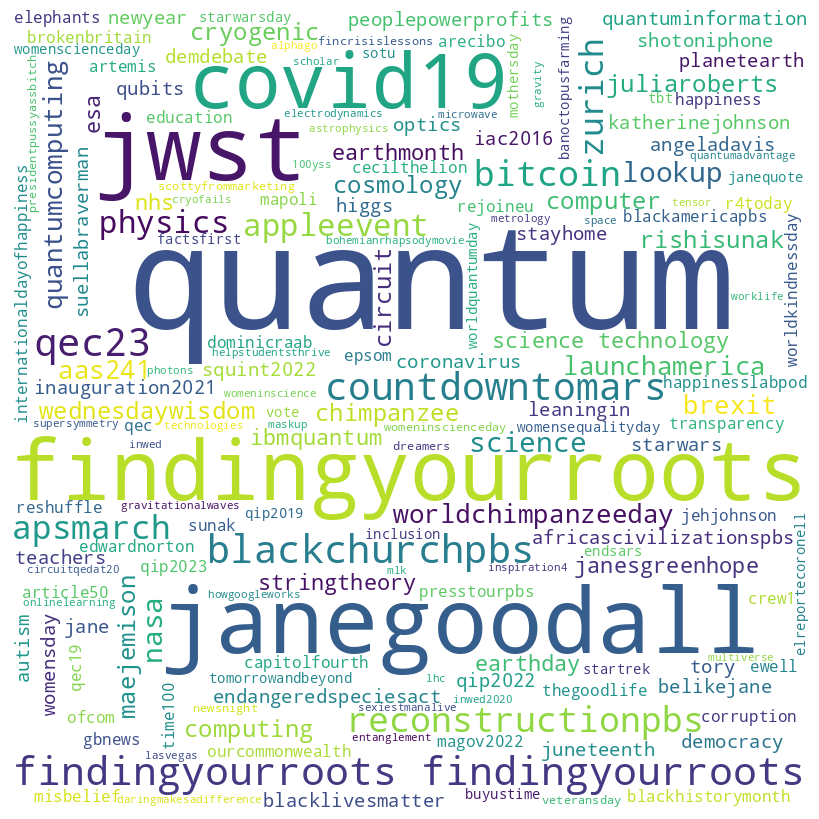

In [115]:
create_wordcloud(flat_hashtags_educated)

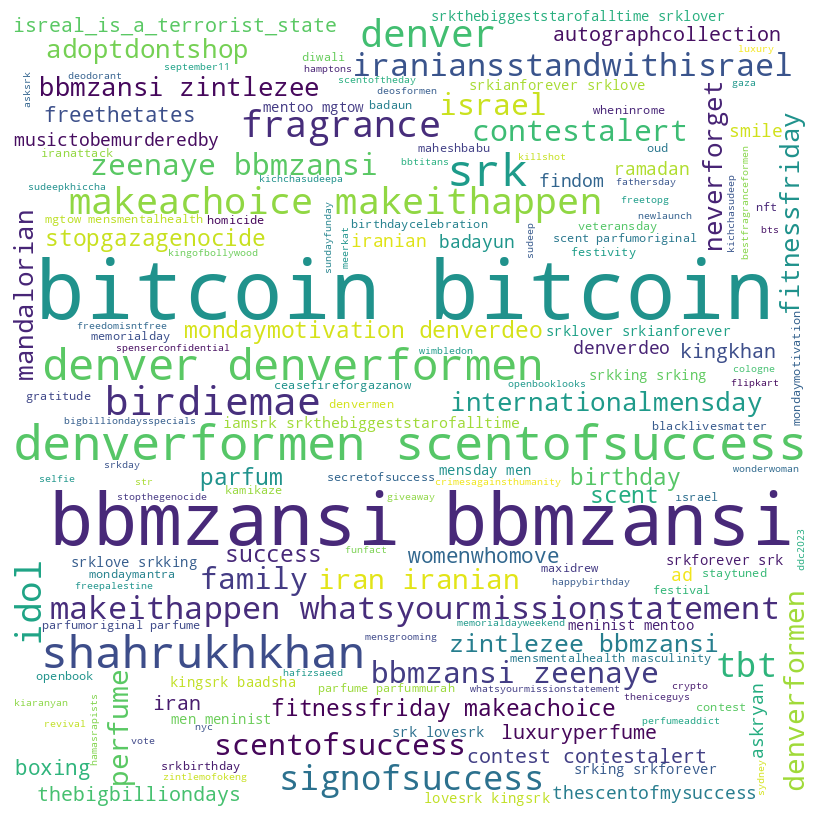

In [116]:
create_wordcloud(flat_hashtags_uneducated)

## Used Emoji

In [117]:
def extract_emojis(text):
    if text is None:
        return ''
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

def process_emojis(df):
    df_emojis = pd.DataFrame()
    for column in df.columns:
        df_emojis[column + '_emojis'] = df[column].apply(extract_emojis)

    all_emojis = ''.join(row for row in df_emojis.apply(lambda x: ''.join(x), axis=1))
    emoji_counts = Counter(all_emojis)
    return emoji_counts

emoji_counts_educated = process_emojis(df_educated)
print('Heterosexual Emoji: ', emoji_counts_educated)

emoji_counts_uneducated = process_emojis(df_uneducated)
print('LGBTQ Emoji: ', emoji_counts_uneducated)



Heterosexual Emoji:  Counter({'🌈': 299, '🏳': 297, '🏀': 198, '♀': 101, '⚛': 101, '🤷': 100, '🏈': 99, '🏞': 99, '🎹': 97, '🐈': 97, '🎉': 13, '👇': 12, '🚀': 12, '❤': 10, '💫': 9, '♥': 8, '😂': 7, '🏽': 7, '✨': 6, '🥳': 6, '😉': 5, '🧵': 5, '💥': 5, '🤣': 5, '🖤': 5, '👏': 4, '🍾': 4, '😳': 4, '🙏': 4, '⬇': 4, '😍': 4, '🔗': 3, '🍍': 3, '🎊': 3, '😀': 3, '♂': 3, '📢': 3, '🎶': 3, '🦆': 3, '🎥': 2, '⚡': 2, '🤩': 2, '🌍': 2, '💔': 2, '😅': 2, '😃': 2, '🧬': 2, '🤓': 2, '🎂': 2, '💚': 2, '😤': 2, '😊': 2, '🍎': 2, '❗': 2, '🤗': 2, '👀': 2, '☀': 2, '📕': 2, '💡': 2, '🙄': 1, '⛪': 1, '👩': 1, '🙌': 1, '🏿': 1, '🐍': 1, '🕷': 1, '🌴': 1, '🏊': 1, '🌕': 1, '🎄': 1, '🥶': 1, '🙂': 1, '😐': 1, '😶': 1, '🍩': 1, '\U0001fae0': 1, '😮': 1, '🤝': 1, '📜': 1, '🙋': 1, '🤖': 1, '😠': 1, '🎨': 1, '🤔': 1, '🤟': 1, '🔥': 1, '🦋': 1, '☢': 1, '💀': 1, '🎈': 1, '💧': 1, '💻': 1, '🦠': 1, '🌵': 1, '☺': 1, '🖥': 1, '🧠': 1, '📦': 1, '😹': 1, '🤘': 1, '👽': 1, '🐕': 1, '🖖': 1, '🚴': 1, '😎': 1, '🌺': 1, '🌹': 1, '😄': 1, '📷': 1, '🔴': 1, '📺': 1, '🏆': 1, '😆': 1, '🏮': 1, '💛': 1, '🧡': 1, '💜': 1, '💙': 

### If you want to see the emojis inside the dataframe of that race.


In [118]:
df_emojis_educated = pd.DataFrame()
for column in df_educated.columns:
    df_emojis_educated[column + '_emojis'] = df_educated[column].apply(extract_emojis)
df_emojis_educated.head(10)

,name_emojis,startUrl_emojis,location_emojis,description_emojis,full_text_emojis
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,
5,,,,,
6,,,,,
7,,,,,
8,,,,,
9,,,,,


### Count of spesific emoji

In [119]:
specific_emoji = "🏴"
emoji_count = emoji_counts_educated.get(specific_emoji, 0)
print(f"Count of {specific_emoji}: {emoji_count}")

Count of 🏴: 0


## Removing emojis or encoding

In [120]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

In [121]:
def preprocess_text(text):
    if text is None:
        return ''

    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    def replace_emoji(match):
        return " " + emoji.demojize(match.group(0)).replace(':', '') + " "

    text = re.sub(emoji_pattern, replace_emoji, text)
    text = ' '.join(text.split())
    return text

In [122]:
df_prep_uneducated['cleaned_text'] = df_prep_uneducated['full_text_processed'].apply(preprocess_text)
df_prep_educated['cleaned_text'] = df_prep_educated['full_text_processed'].apply(preprocess_text)



## Replace \\n with whitespace

In [123]:
def remove_newlines(df, column_name):
    df[column_name] = df[column_name].str.replace('\n', ' ')
    return df

df_prep_educated = remove_newlines(df_prep_educated, 'cleaned_text')
df_prep_uneducated = remove_newlines(df_prep_uneducated, 'cleaned_text')


## Deleting extra whitespaces

In [124]:
def replace_multiple_spaces(df, column_name):
    df[column_name] = df[column_name].str.replace(r'\s+', ' ')
    return df

# Example usage
df_prep_educated = replace_multiple_spaces(df_prep_educated, 'cleaned_text')
df_prep_uneducated = replace_multiple_spaces(df_prep_uneducated, 'cleaned_text')


df_prep_educated.head()

,name,startUrl,location,description,full_text_processed,cleaned_text
0,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"For too long, Rishi Sunak has allowed tax dodg...",for too long rishi sunak has allowed tax dodge...
1,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"Britain’s pensioners deserve certainty, and fo...",britain’s pensioners deserve certainty and for...
2,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It’s fantastic to welcome Dr Dan Poulter MP to...,it’s fantastic to welcome dr dan poulter mp to...
3,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was an honour to meet with @3dadswalking to...,it was an honour to meet with 3dadswalking tod...
4,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was a pleasure speaking with @GylesB1 about...,it was a pleasure speaking with gylesb1 about ...


## Replace undurscore with whitespace

In [125]:
def remove_newlines(df, column_name):
    df[column_name] = df[column_name].str.replace('_', ' ')
    return df

df_prep_educated = remove_newlines(df_prep_educated, 'cleaned_text')
df_prep_uneducated = remove_newlines(df_prep_uneducated, 'cleaned_text')


In [126]:
df_prep_educated.head()

,name,startUrl,location,description,full_text_processed,cleaned_text
0,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"For too long, Rishi Sunak has allowed tax dodg...",for too long rishi sunak has allowed tax dodge...
1,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,"Britain’s pensioners deserve certainty, and fo...",britain’s pensioners deserve certainty and for...
2,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It’s fantastic to welcome Dr Dan Poulter MP to...,it’s fantastic to welcome dr dan poulter mp to...
3,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was an honour to meet with @3dadswalking to...,it was an honour to meet with 3dadswalking tod...
4,Keir Starmer,Keir_Starmer,United Kingdom,MP for Holborn and St Pancras and Leader of th...,It was a pleasure speaking with @GylesB1 about...,it was a pleasure speaking with gylesb1 about ...


## Showing rows with less than 3 characters

In [127]:
print(df_prep_educated.shape)
print(df_prep_uneducated.shape)

(6449, 6)
(7628, 6)


In [128]:
def filter_dataframe(df):
    filtered_df = df[df['cleaned_text'].str.len() < 3]
    df = df.drop(filtered_df.index)
    return df

df_prep_educated = filter_dataframe(df_prep_educated)
df_prep_uneducated = filter_dataframe(df_prep_uneducated)


In [129]:
print(df_prep_educated.shape)
print(df_prep_uneducated.shape)

(6368, 6)
(7291, 6)


# Merge dataframes

In [130]:
df_prep_educated['education'] = 'educated'
df_prep_uneducated['education'] = 'uneducated'


In [131]:
print(df_prep_educated.shape)
print(df_prep_uneducated.shape)


(6368, 7)
(7291, 7)


In [132]:
df_merged = pd.concat([df_prep_educated, df_prep_uneducated], ignore_index=True)
columns_to_drop = ['name', 'location', 'description','full_text_processed']
df_merged = df_merged.drop(columns=columns_to_drop)
print(df_merged.shape)
df_merged.head()

(13659, 3)


,startUrl,cleaned_text,education
0,Keir_Starmer,for too long rishi sunak has allowed tax dodge...,educated
1,Keir_Starmer,britain’s pensioners deserve certainty and for...,educated
2,Keir_Starmer,it’s fantastic to welcome dr dan poulter mp to...,educated
3,Keir_Starmer,it was an honour to meet with 3dadswalking tod...,educated
4,Keir_Starmer,it was a pleasure speaking with gylesb1 about ...,educated


# Advanced Methods for predicttion

efore applying BPE to the pre-training corpus of English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets.

Given the raw input Tweets, to obtain the same pre-processing output, users could employ our TweetNormalizer module.

Installation: pip3 install nltk emoji==0.6.0
The emoji version must be either 0.5.4 or 0.6.0. Newer emoji versions have been updated to newer versions of the Emoji Charts, thus not consistent with the one used for pre-processing our pre-training Tweet corpus.

from TweetNormalizer import normalizeTweet


In [133]:
print(df_merged.isnull().sum())

startUrl        0
cleaned_text    0
education       0
dtype: int64


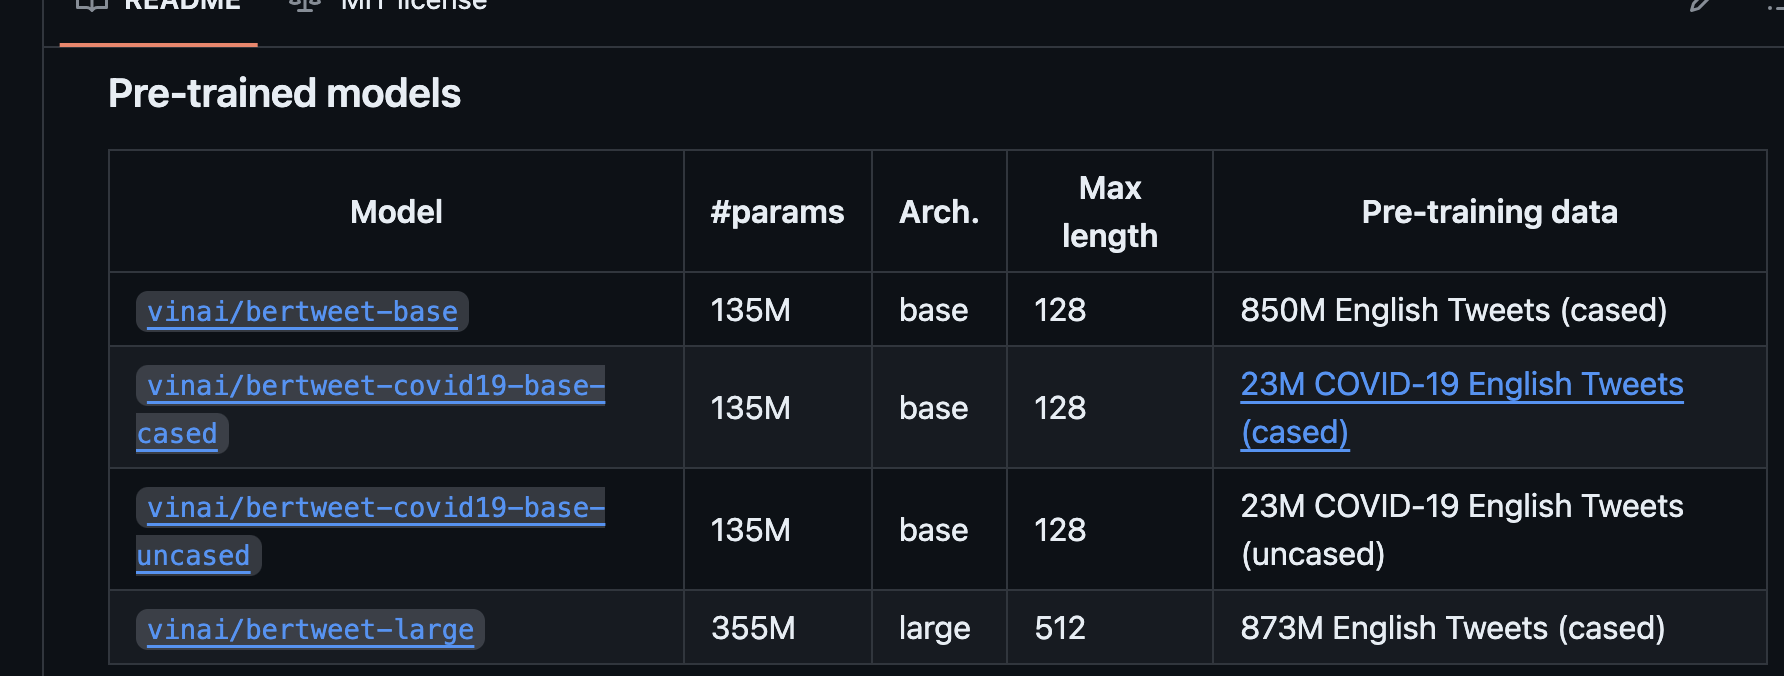

Install transformers with pip: pip install transformers, or install transformers from source.
Note that we merged a slow tokenizer for BERTweet into the main transformers branch. The process of merging a fast tokenizer for BERTweet is in the discussion, as mentioned in this pull request. If users would like to utilize the fast tokenizer, the users might install transformers as follows:
git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
cd transformers
pip3 install -e .

In [134]:
!pip install optuna

In [135]:
!pip install transformers
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split

In [136]:
model = AutoModel.from_pretrained("vinai/bertweet-large")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", normalization=True)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We employ the transformers library (Wolf
et al., 2019) to independently fine-tune BERTweet
for each task and each dataset in 30 training
epochs. We use AdamW (Loshchilov and Hutter, 2019) with a fixed learning rate of 1.e-5 and
a batch size of 32 (Liu et al., 2019). We compute
the task performance after each training epoch on
the validation set (here, we apply early stopping
when no improvement is observed after 5 continuous epochs)

each pre-trained language model the “soft” scores
are generally higher than the corresponding “hard”
scores, i.e. applying lexical normalization dictionaries to normalize word tokens in Tweets generally does not help improve the performance of the
pre-trained language models on downstream tasks

In [137]:
#dataset object that can be passed to a PyTorch DataLoader for batching and iterating over
#handles the tokenization and encoding of text inputs using the provided tokenizer
class CustomDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) #ensure that the text is in a format that can be processed by the tokenizer.
        target = self.targets[idx]
        try:
            encoding = self.tokenizer.encode_plus(
            text, #This is the input text that we want to encode.
            add_special_tokens=True, #This parameter specifies that special tokens like [CLS] (start of sequence) and [SEP] (end of sequence) should be added to the input text. These tokens are required for RoBERTa.
            max_length=self.max_len, #f the input text is longer than this length, it will be truncated. If it is shorter, it will be padded.
            return_token_type_ids=None,  # DIfferent than bert, Make sure no token type IDs are returned as they are not required for RoBERTa
            padding='max_length',
            truncation=True,
            return_attention_mask=True,#The attention mask is a binary mask indicating which tokens are actual words and which are padding tokens.
            return_tensors='pt' #specifies that the output should be returned as PyTorch tensors ('pt').
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),#token IDs of the input text.
                'attention_mask': encoding['attention_mask'].flatten(),# which indicates which tokens are real words and which are padding tokens.
                'targets': torch.tensor(target, dtype=torch.long) #integer
            }
        except KeyError as e:
            print(f"Index Error: {idx} not found.")
            raise


In [138]:
print(df_merged['education'].unique())
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_merged['education'] = le.fit_transform(df_merged['education'])

print(df_merged['education'].unique())

['educated' 'uneducated']
[0 1]


In [139]:
from torch.nn.utils.rnn import pad_sequence
#combine a batch of samples into a single batch
def custom_collate_fn(batch):
  input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True) #pad the sequences to the same length.
  attention_masks = pad_sequence([item['attention_mask'] for item in batch], batch_first=True)#same as above but for the 'attention_mask'.
  targets = torch.stack([item['targets'] for item in batch]) #extracts the 'targets' from each item in the batch and then stacks them into a single tensor
  return {'input_ids': input_ids, 'attention_mask': attention_masks, 'targets': targets} #eturns a dictionary containing the padded input IDs, attention masks, and targets as a single batch

In [140]:
df_full_train, df_test = train_test_split(df_merged, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)


#80-10-10


df_train = df_train.reset_index(drop=True)#reset the index of a DataFrame, drop the old index and replace it with a new sequential index
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Best parameters from tuning
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
DROPOUT_RATE = 0.4
WARMUP_STEPS = 0
MAX_LEN = 128

train_data = CustomDataset(df_train['cleaned_text'], df_train['education'], tokenizer, MAX_LEN)
val_data = CustomDataset(df_val['cleaned_text'], df_val['education'], tokenizer, MAX_LEN)
test_data = CustomDataset(df_test['cleaned_text'], df_test['education'], tokenizer, MAX_LEN)

#data loader batching automatically batches the data, which means it combines individual samples into batches
#GPUs can process batches of data faster than individual samples.
#shuffle for ensure that the model doesn't learn the order of the data
#DataLoader takes care of loading the data in parallel,
#collate_fn for if samples have different sizes or structures.
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [141]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [142]:
from torch import nn
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import optuna

with torch.no_grad():
    features = bertweet(input_ids)  # Models outputs are now tuples


https://github.com/VinAIResearch/BERTweet/blob/e36876c673438159de0233e9b1e9eee61d8902b3/README.md?plain=1#L78

In [143]:
EPOCHS = 100
class EducationClassifier(nn.Module):

    def __init__(self, n_classes, drop_rate=DROPOUT_RATE):
        super(EducationClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")
        self.drop = nn.Dropout(p=drop_rate)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #linear layer for the output with the number of classes

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        last_hidden_state = bert_output[0]
        pooled_output = last_hidden_state[:, 0]
        output = self.drop(pooled_output)
        return self.out(output)

n_classes = len(df_merged['education'].unique())
model = EducationClassifier(n_classes)
model = model.to(device) #passed to gpu


#higher weights to the minority class
class_weights = compute_class_weight('balanced', classes=np.unique(df_train.education), y=df_train.education) #computed based on the class distribution in the training dataset
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)#measures the performance of a classification model whose output is a probability value between 0 and 1
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) # need  look at the paper for proper param

#will be used by step function
scheduler = get_linear_schedule_with_warmup( #prevent the model from diverging early on.
  optimizer,
  num_warmup_steps=WARMUP_STEPS,
  num_training_steps=len(train_dataloader) * EPOCHS
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

## Result

### Hyperparameter Tuning

In [ ]:
from transformers import AutoModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm


In [ ]:
def train_and_evaluate_model(trial, train_dataloader, val_dataloader, device, num_epochs, n_classes):
    # Define the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)

    model = EducationClassifier(n_classes=n_classes, drop_rate=dropout_rate).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=len(train_dataloader) * num_epochs
    )

    class_weights = compute_class_weight('balanced', classes=np.unique(df_train.education), y=df_train.education)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train
        model.train()
        for _, data in enumerate(tqdm(train_dataloader)):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        val_loss = 0.0
        for _, data in enumerate(val_dataloader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)

        trial.report(avg_val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return best_val_loss

In [ ]:
def objective(trial):
    max_len = 128
    train_dataset = CustomDataset(df_train['cleaned_text'], df_train['education'], tokenizer, max_len)
    val_dataset = CustomDataset(df_val['cleaned_text'], df_val['education'], tokenizer, max_len)

    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    return train_and_evaluate_model(trial, train_dataloader, val_dataloader, device, num_epochs=3, n_classes=n_classes)


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_trial = study.best_trial
print(f"Best trial final loss value: {best_trial.value}")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-06-05 11:01:11,776] A new study created in memory with name: no-name-ded1ebd9-6bed-4274-bbce-4dc1bd124f06
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 257/257 [00:42<00:00,  5.99it/s]
[I 2024-06-05 11:03:37,965] Trial 0 finished with value: 0.5261390871086786 and parameters: {'batch_size': 32, 'learning_rate': 1.132386917333908e-05, 'dropout_rate': 0.33201494861296343, 'warmup_steps': 199}. Best is trial 0 with value: 0.5261390871086786.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` t

Best trial final loss value: 0.3785570161253737
batch_size: 8
learning_rate: 5.0904198248047216e-05
dropout_rate: 0.42855417894359493
warmup_steps: 153


### Train part

In [145]:
from tqdm import tqdm



Epoch: 1/100, Train Loss:  0.627
Train Accuracy: 65.09 %
Validation Loss: 0.573



Epoch: 2/100, Train Loss:  0.535
Train Accuracy: 74.13 %
Validation Loss: 0.535



Epoch: 3/100, Train Loss:  0.406
Train Accuracy: 81.93 %
Validation Loss: 0.457



Epoch: 4/100, Train Loss:  0.289
Train Accuracy: 88.21 %
Validation Loss: 0.437



Epoch: 5/100, Train Loss:  0.192
Train Accuracy: 92.85 %
Validation Loss: 0.511



Epoch: 6/100, Train Loss:  0.128
Train Accuracy: 95.63 %
Validation Loss: 0.803



Epoch: 7/100, Train Loss:  0.084
Train Accuracy: 97.12 %
Validation Loss: 0.625



Epoch: 8/100, Train Loss:  0.065
Train Accuracy: 97.91 %
Validation Loss: 0.686



Epoch: 9/100, Train Loss:  0.052
Train Accuracy: 98.50 %
Validation Loss: 0.696



Epoch: 10/100, Train Loss:  0.048
Train Accuracy: 98.50 %
Validation Loss: 0.794
Early stopping


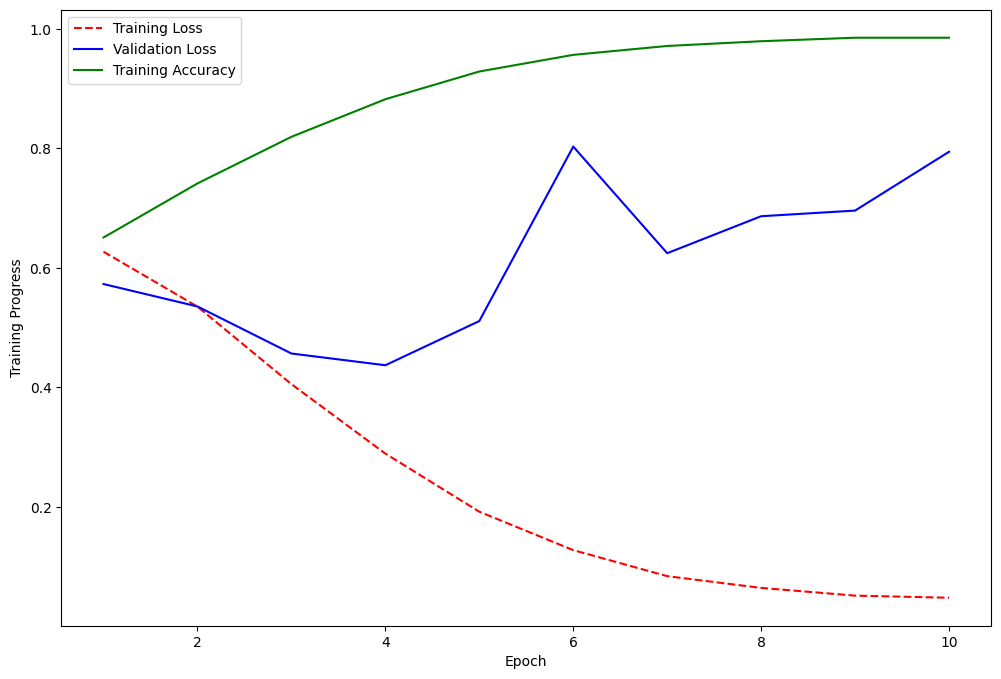

In [146]:
import numpy as np
import matplotlib.pyplot as plt

PATIENCE = 5  # number of epochs to wait before stopping, same as the paper BERTweet

train_loss_values = []
val_loss_values = []
accuracy_values = []

best_loss = np.inf
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_predictions = 0
    total = 0

    # Use tqdm to show a progress bar
    for _, data in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False, ncols=80)):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    average_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total

    train_loss_values.append(average_train_loss)
    accuracy_values.append(train_accuracy)

    # Print the summary of the current epoch
    print(f'\nEpoch: {epoch+1}/{EPOCHS}, Train Loss:  {average_train_loss:.3f}')
    print(f'Train Accuracy: {100 * train_accuracy:.2f} %')

    # Validation
    val_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_dataloader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    average_val_loss = val_loss / len(val_dataloader)
    val_loss_values.append(average_val_loss)
    print(f'Validation Loss: {average_val_loss:.3f}')

    # Check for early stopping
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), 'best_model_education.pt')
    else:
        patience_counter += 1

    if patience_counter > PATIENCE:
        print("Early stopping")
        break

epoch_count = range(1, len(train_loss_values) + 1)
model.load_state_dict(torch.load('best_model_education.pt'))

plt.figure(figsize=(12, 8))
plt.plot(epoch_count, train_loss_values, 'r--')
plt.plot(epoch_count, val_loss_values, 'b-')
plt.plot(epoch_count, accuracy_values, 'g-')
plt.legend(['Training Loss', 'Validation Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Progress')
plt.show()


### Test Set

In [147]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Your model evaluation code
model.eval()
test_loss = 0
correct_predictions = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['targets'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct_predictions / total
num_test_tweets = len(df_test)
incorrect_predictions = [(text, label, pred) for text, label, pred in zip(df_test['cleaned_text'], all_labels, all_predictions) if label != pred]

print(f'Number of tweets in the test set: {num_test_tweets}')
num_incorrect_predictions = len(incorrect_predictions)
print(f'Number of incorrect predictions: {num_incorrect_predictions}\n')
print(f'\nTest Loss: {average_test_loss:.3f}')
print('Test Accuracy: {:.2f} %'.format(100 * test_accuracy))

label_mapping = {0: 'uneducated', 1: 'educated'}
all_predictions_str = [label_mapping[pred] for pred in all_predictions]
all_labels_str = [label_mapping[label] for label in all_labels]

# Display incorrect predictions
incorrect_predictions = [(text, actual, pred) for text, actual, pred in zip(df_test['cleaned_text'], all_labels_str, all_predictions_str) if actual != pred]
print("\nIncorrect Predictions:")
for text, actual, pred in incorrect_predictions:
    print(f"Text: {text}\nActual: {actual}\nPredicted: {pred}\n")

# Calculate additional metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=list(label_mapping.values()))
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Number of tweets in the test set: 2732
Number of incorrect predictions: 531


Test Loss: 0.463
Test Accuracy: 80.56 %

Incorrect Predictions:
Text: for ahmaud arbery and his family and all of us justice brings a resolution but cannot bring consolation for loss it is ever thus this is why our goal must be safety for all first up front i am working amp fighting for a world where ahmaud on his run would have been safe
Actual: uneducated
Predicted: educated

Text: “only a life lived for others is a life worthwhile ― albert einstein
Actual: uneducated
Predicted: educated

Text: two physicists caltech
Actual: uneducated
Predicted: educated

Text: do not miss this important insightful book by jen pan welfare for autocrats id also say it is timely but if you read it a couple of decades from now i think youll likely say it is timely then too congratulations jenjpan
Actual: uneducated
Predicted: educated

Text: kkv take 2
Actual: uneducated
Predicted: educated

Text: do not trust anyone who uses

## Test with unseen data

### Predicting the labels

In [148]:
model.load_state_dict(torch.load('best_model_education.pt', map_location=device))
model.eval()

def text_to_loader(tokenizer, texts, max_len):
    encoding = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return [{
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
    }]

def predict(model, dataloader):
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for item in dataloader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)

    return [le.inverse_transform([pred.item()])[0] for pred in predictions]  # Invert


In [149]:
unseen_texts = ["i hate reading book"]
true_labels = ["uneducated"]

MAX_LEN = 100
test_dataloader = DataLoader(text_to_loader(tokenizer, unseen_texts, MAX_LEN), batch_size=1)

predictions = predict(model, test_dataloader)

for text, true, pred in zip(unseen_texts, true_labels, predictions):
    print(f'Text: {text}')
    print(f'Predicted: {pred}, Actual: {true}\n')

Text: i hate reading book
Predicted: uneducated, Actual: uneducated



### Giving probs for labes

In [150]:
def predict_probabilities(model, dataloader):
    model = model.eval()
    all_probs = []

    with torch.no_grad():
        for item in dataloader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs)

    return all_probs


In [151]:
probabilities = predict_probabilities(model, test_dataloader)
unseen_texts = ["i hate reading book"]
true_labels = ["uneducated"]

In [152]:
for text, true, probs in zip(unseen_texts, true_labels, probabilities):
    label_probs = {le.inverse_transform([i])[0]: prob.item() for i, prob in enumerate(probs[0])}
    print(f'Text: {text}')
    print(f'Label Probabilities: {label_probs}, Actual: {true}\n')

Text: i hate reading book
Label Probabilities: {'educated': 0.16043131053447723, 'uneducated': 0.8395687341690063}, Actual: uneducated



### Multiple sentence

In [153]:
# Sample sentences
sentences = [
#Educated

"I have a college degree.",
"I value higher education.",
"I enjoy learning new things.",
"I believe education is important.",
"I have a thirst for knowledge.",
"I like to engage in intellectual discussions.",
"I appreciate the value of research.",
"I have a passion for academia.",
"I strive to expand my knowledge.",
"I respect the opinions of experts.",
#Uneducated
"I do not have a formal education.",
"I did not attend college.",
"I have not pursued higher education.",
"I rely on life experience rather than formal education.",
"I prefer practical skills over academic knowledge.",
"I believe in learning through hands-on experience.",
"I am self-taught in many areas.",
"I value street smarts over book smarts.",
"I think formal education is overrated.",
"I do not feel the need for a college degree.",
]

# Corresponding expected races
expected_races = [
    "educated", "educated", "educated", "educated", "educated", "educated", "educated", "educated", "educated", "educated",
    "uneducated", "uneducated", "uneducated", "uneducated", "uneducated", "uneducated", "uneducated", "uneducated", "uneducated", "uneducated",
]

encoded_sentences = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LEN,
)

input_ids = encoded_sentences["input_ids"].to(device)
attention_mask = encoded_sentences["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    predictions = predictions.cpu().numpy()

predicted_labels = le.inverse_transform(predictions)
label_counts = {}
correct_counts = {}

for label in le.classes_:
    label_counts[label] = 0
    correct_counts[label] = 0

for pred, expected in zip(predicted_labels, expected_races):
    label_counts[expected] += 1
    if pred == expected:
        correct_counts[expected] += 1

print("True Prediction Ratios:")
for label in le.classes_:
    correct_predictions = correct_counts[label]
    total_predictions = label_counts[label]
    ratio = correct_predictions / total_predictions * 100 if total_predictions > 0 else 0
    print(f"{label}: {ratio:.2f}% (Total: {total_predictions}, Correct: {correct_predictions})")

print("\nIndividual Predictions:")

for i, (sentence, prediction, expected_race) in enumerate(zip(sentences, predicted_labels, expected_races)):
    print(f"Sentence {i+1}: '{sentence}'")
    print(f"Predicted: {prediction}, Expected: {expected_race}\n")


True Prediction Ratios:
educated: 10.00% (Total: 10, Correct: 1)
uneducated: 80.00% (Total: 10, Correct: 8)

Individual Predictions:
Sentence 1: 'I have a college degree.'
Predicted: uneducated, Expected: educated

Sentence 2: 'I value higher education.'
Predicted: uneducated, Expected: educated

Sentence 3: 'I enjoy learning new things.'
Predicted: uneducated, Expected: educated

Sentence 4: 'I believe education is important.'
Predicted: uneducated, Expected: educated

Sentence 5: 'I have a thirst for knowledge.'
Predicted: uneducated, Expected: educated

Sentence 6: 'I like to engage in intellectual discussions.'
Predicted: educated, Expected: educated

Sentence 7: 'I appreciate the value of research.'
Predicted: uneducated, Expected: educated

Sentence 8: 'I have a passion for academia.'
Predicted: uneducated, Expected: educated

Sentence 9: 'I strive to expand my knowledge.'
Predicted: uneducated, Expected: educated

Sentence 10: 'I respect the opinions of experts.'
Predicted: uned

In [154]:
sentences = [
	"tbh, i still show up to my home office a few times a week"
	"Memes are modern wisdom literature."
"People who love lists of mistakes are into errataca."
"He’s not really that dumb, right? No person of his reputation could possibly be that dumb. It must all be an act, right? Right? Right???"
]
#use comma for every sentence if you want them used seperately
#https://twitter.com/tunguz Predicted white actual white



encoded_sentences = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LEN,
)

input_ids = encoded_sentences["input_ids"].to(device)
attention_mask = encoded_sentences["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    predictions = predictions.cpu().numpy()

predicted_labels = le.inverse_transform(predictions)

expected_race = "educated" ####################################
expected_label = le.transform([expected_race])[0]

for i, prediction in enumerate(predicted_labels):
    actual_class = le.inverse_transform([expected_label])[0] if expected_label in predictions else expected_race
    print(f"Sentence {i+1}: '{sentences[i]}'")
    print(f"Predicted: {prediction}, Expected: {actual_class}\n")

Sentence 1: 'tbh, i still show up to my home office a few times a weekMemes are modern wisdom literature.People who love lists of mistakes are into errataca.He’s not really that dumb, right? No person of his reputation could possibly be that dumb. It must all be an act, right? Right? Right???'
Predicted: uneducated, Expected: educated

